# The Colocation Analysis Notebook

## Introduction

[Colocation Analysis](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/learnmorecolocationanalysis.htm) (CA) "measures local patterns of spatial association between two categories of point features using the colocation quotient statistic" ([esri documentation](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/learnmorecolocationanalysis.htm)). In other words, it tests whether category A tends to occur in the proximity of category B and it measures how strong this tendency is. 

The quantification of this tendency is the mentioned local colocation quotient (LCLQ). This quotient is calculated for every point of category A (category of interest) and determines whether each point is colocated with points of category B (neighbouring category) or isolated. 

"In general, if the proportion of B points within the neighborhood of A point is more than the global proportion of category B in the study area, the LCLQ will be high" ([esri documentation](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/learnmorecolocationanalysis.htm)). When the LCLQ is greater than 1, the A point is colocated, when the LCLQ is smaller than 1, the A point is isolated. The next picture from the [CA tool documentation](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/colocationanalysis.htm) simply illustrates the concept of CA.

<img src="https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/GUID-DD92E901-1AC8-4465-AA3B-241A9FFA8592-web.png" />

This notebook is a practical guide which will help you understand what colocation analysis actually is. Using the example of the Katowice conurbation and the [Urban Atlas Land Use/Land Cover](https://land.copernicus.eu/en/products/urban-atlas/urban-atlas-2018?tab=download) (UA LULC) dataset you will go through the whole process from data editing to results interpretation and visualization.

The notebook is divided into 6 consequently following sections:

* [Workspace and data preparation](#data)
* [Colocation Analysis settings](#settings)
* [Spatial interpretation of the results](#interpretation) 
* [Running multiple analyses](#multiple)
* [Visualization of results by chart](#charts)
* [Calculation of colocation quotient](#math)

Here are some practical points that are good to keep in mind before you start: this notebook is a part of this ArcGIS Pro project. If you are familiar with ArcGIS Notebooks and ArcGIS Pro, after a few changes in the code you can use this notebook outside of this project, but if you are a beginner, use and run this notebook here. There is also a folder with the Urban Atlas data for the Katowice Functional Urban Area (FUA) in the folder where both the project and the notebook are stored. 

Some code cells produce a change in the map, so it's recommended to have either two monitors – one for the notebook and one for the map, or split the screen in half between those two, or just follow the notebook and switch to the map when something happens there.

This notebook was developed and tested in ArcGIS Pro 3.0.2 using cloned Python 3.9.18 environment. For table and graph visualization, 2 external libraries were installed in this environment: [**pandas**](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwipnMeyie-EAxXOgP0HHfmgBvUQFnoECAcQAQ&url=https%3A%2F%2Fpandas.pydata.org%2F&usg=AOvVaw3cD5ulu4AnZcNusojIyttY&opi=89978449) and [**matplotlib**](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjQjea1ie-EAxVKh_0HHQTrCeAQFnoECAcQAQ&url=https%3A%2F%2Fmatplotlib.org%2F&usg=AOvVaw0YgZr7XYZzco6IDaGIE2sw&opi=89978449). You can install them using Package manager in the Project tab, by typing the library name in the Add package section like this:

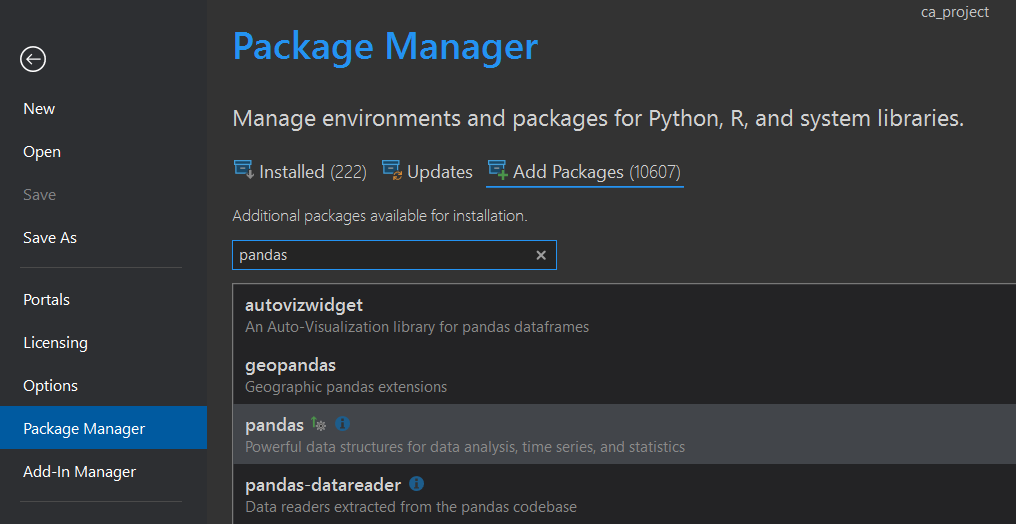

Feel free to download any other city from the Urban Atlas database and use it instead of Katowice, this notebook will work perfectly except for the "Spatial interpretation of the results" part, because there are created bookmarks for Katowice. For smooth transition to your chosen city add the Urban Atlas data folder to the same parent folder and change the paths in the 4th and 5th code cell.

## Workspace and data preparation <a class="anchor" id="data"></a>

In this part you will set up the workspace, save names of important layers into variables and prepare UA LULC dataset for the CA. That includes clipping dataset to required extent, aggregating UA LULC categories into groups and converting the original polygon layer into a point layer.

The first step is to import [**ArcPy**](https://pro.arcgis.com/en/pro-app/arcpy/get-started/what-is-arcpy-.htm), python package that enables users to access ArcGIS functions, objects, geoprocessing tools and environment settings. 

Then a file geodatabase is set as the workspace, where the inputs will be taken from and the outputs will be saved. The geodatabase used here is located in the same directory as this ArcGIS Pro project. If you want to use a different geodatabase, write down the path to it instead. 

By setting [overwriteOutput](https://pro.arcgis.com/en/pro-app/latest/arcpy/classes/env.htm) property to *```True```*, tools are allowed to overwrite an existing layer with a new one when the output name is the same.

In [ ]:
import arcpy
arcpy.env.workspace = "\ca_project.gdb"
arcpy.env.overwriteOutput = True
print(arcpy.env.workspace)

Now you'll save the workspace path to the variable ```path``` and replace backslashes with common slashes. You'll need your workspace path with this type of slashes later.

In [ ]:
path = arcpy.env.workspace
path = path.replace("\\", "/")
path = path.replace("//", "/")
print(path)

**ArcPy** consists of several submodules and one of them is [**mp**](https://pro.arcgis.com/en/pro-app/3.1/arcpy/mapping/introduction-to-arcpy-mp.htm). Using this submodule it is possible to access this ArcGIS Pro project, maps, layouts, layers, symbology and so on. Save this ArcGIS Pro project into variable ```project``` and its map into variable ```my_map```. If the name of your map is different from the default ```"Map"```, type it in its place.

Here is the list of all [arcpy.mp classes](https://pro.arcgis.com/en/pro-app/latest/arcpy/mapping/alphabeticallistofclasses.htm) with their methods and properties. It's very helpful and you'll find several methods and properties throughout this notebook that come from that list.

In [ ]:
project = arcpy.mp.ArcGISProject("CURRENT")
my_map = project.listMaps("Map")[0]

The ```source_clipped``` variable contains the name for the output layer of the [**Clip**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/analysis/clip.htm) tool.

Downloaded Urban Atlas layers are stored in a geopackage format and have been imported into the project's geodatabase. You can find there 2 layers: the first one is the UA LULC layer and the second one is a single polygon that determines the boundaries of Katowice Urban Core.

In [ ]:
source_clipped = "katowice_ua"
ua_lulc = "main_PL010L2_KATOWICE_UA2018"
urban_core = "main_PL010L2_KATOWICE_UA2018_UrbanCore"

The **Clip** tool takes the source layer and clips it by the Urban Core polygon. The reason is that you want to explore colocation patterns in an urban environment and the source layer contains the whole FUA which includes a rural environment as well.

In [ ]:
# simple if statement that prevents from useless running the same function over and over again
# such if statements with the Exists method are found throughout the notebook
if arcpy.Exists(source_clipped):
    print("UA LULC layer is already clipped.")
else:
    arcpy.analysis.Clip(ua_lulc, urban_core, source_clipped)
    print("UA LULC layer successfully clipped.")

Here's the scheme of the clipping you did in the previous cell:

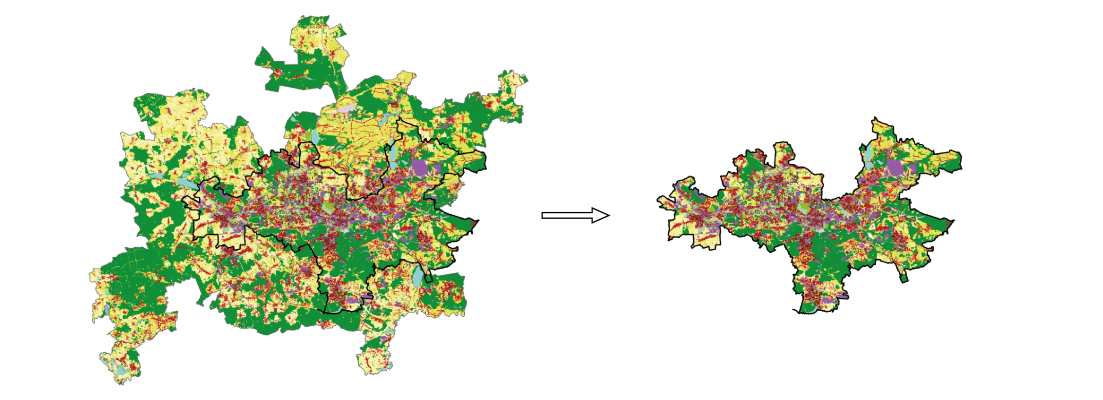

Now check if the clipped layer is in your map. You can do that by listing all layers from your map with a name stored in the variable ```source_clipped```.

In [ ]:
mylist = my_map.listLayers(source_clipped)

If the number of list's elements is greater than 0, print a message that the clipped layer is already in the map. If not, add it to the map by [**addDataFromPath**](https://pro.arcgis.com/en/pro-app/3.1/arcpy/mapping/map-class.htm) method, where you use the variable ```path```.

In [ ]:
if len(mylist)>0:
    print("Clipped layer is already in your map.")
else:
    my_map.addDataFromPath(path + "/" + source_clipped)

Now you'll apply the Urban Atlas symbology which was downloaded with the data and stored as .lyr, .qml and .sld file. ArcGIS Pro can read .lyr files and using the [**Apply Symbology From Layer**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/apply-symbology-from-layer.htm) tool it was applied to the full UA LULC layer. After clipping it by the Urban Core it should be automatically applied to the clipped layer in the map. If not, you can apply it using just this one line of code.

In [ ]:
arcpy.management.ApplySymbologyFromLayer(source_clipped, ua_lulc)

Since UA LULC dataset has too many categories (25) they have to be clustered before the CA is performed. New clusters are grouping similar categories together, they usually share the same first two numbers in their land use code.

For example categories that start with ```"11"``` are urban fabric buildings and there are 6 such categories, so instead of 6 single categories there will be only 1 group representing them. So from 25 categories you'll go down to 11 groups as a result.

These groups will be written into a new field named ```"ctgr_group"``` which will be added by [**Add Field**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/add-field.htm) tool. First you need to check if this field is already in the clipped layer and if not, then create it.

In [ ]:
new_field = "ctgr_group"
# get the list of all fields in the clipped layer that have a name "ctgr_group" and are of text type
fields = arcpy.ListFields(source_clipped, "ctgr_group", "String")   

if len(fields)>0:
    print(f"Text field named {new_field} is already present in layer {source_clipped}.")
else:
    arcpy.management.AddField(source_clipped, new_field, "TEXT")
    print(f"New text field named {new_field} successfully added.")

The [cursor](https://pro.arcgis.com/en/pro-app/latest/arcpy/get-started/data-access-using-cursors.htm) (data access object) in the update form will be used to populate the new ```"ctgr_group"``` field. For loop will iterate over rows in the dataset and each row will be assigned new group name based on the land use code. Some categories which are not suitable to group with any other category will form groups by themselves.

In [ ]:
# a simple control that uses the count of selected features with null value as a condition to run
control = arcpy.management.SelectLayerByAttribute(source_clipped, "NEW_SELECTION", "ctgr_group IS NULL")

# run the Update cursor only if there are some null values in 'ctgr_group' field
if int(control[1]) > 0:
    fields = ["code_2018", "class_2018", new_field]

    with arcpy.da.UpdateCursor(source_clipped, fields) as cursor:
        for row in cursor:
            # here are the rules which are creating new groups
            if row[0][:2] == "11":
                row[2] = "urban fabric"
            elif (row[0][:2] == "12") and (row[0][:3] != "121"):
                row[2] = "transport"
            elif row[0][:2] == "13":
                row[2] = "brownfields"
            elif row[0][:2] == "14":
                row[2] = "relax"
            elif row[0][0] == "2":
                row[2] = "agriculture"
            # the next 3 groups represent 3 single categories
            # but their group names are shortened because their category names are too long 
            elif row[0] == "12100":
                row[2] = "icpmp units"
            elif row[0] == "32000":
                row[2] = "herbaceous vegetation"
            elif row[0] == "33000":
                row[2] = "open spaces"
            # categories Forests, Wetlands and Water will become independent groups with the same name
            # but in order to keep the style, their first letter will be lowercase
            else:
                row[2] = row[1].lower()

            cursor.updateRow(row)

    print(f"The field {new_field} was populated with new groups.")
    
# if a new group is assigned to each feature, print out the message
else:
    print(f"New groups are already present in the field {new_field}")
    
arcpy.management.SelectLayerByAttribute(source_clipped, "CLEAR_SELECTION")

In the next cell you are going to create an input point layer for the [**Colocation Analysis**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/colocationanalysis.htm) tool (**CA tool**).

The first step is to select polygons of category of interest (A) and neighbouring category (B) by the [**Select Layer By Attribute**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/select-layer-by-attribute.htm) tool and save this selection in the ```ab_only``` variable. In this case, category of interest is the ```"urban fabric"``` group and neighbouring category is the ```"relax"```  group (categories "green urban areas" and "sports and leisure facilities").

These selected polygons become an input for the [**Feature To Point**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/feature-to-point.htm) tool, which will create a point layer from them by generating centroids. For this use case you want to make sure that centroids will be inside their respective polygons, so just write ```"INSIDE"``` as the 3rd parameter of the tool.

Variable ```ab_points``` contains the input point layer name.

In [ ]:
ab_points = "urban_relax_points"

if arcpy.Exists(ab_points):
    print("A point layer containing only A and B categories already exists in your geodatabase.")
else:
    ab_only = arcpy.management.SelectLayerByAttribute(source_clipped, "NEW_SELECTION", 
                                                    "ctgr_group = 'urban fabric' OR ctgr_group = 'relax'")
    arcpy.management.FeatureToPoint(ab_only, ab_points, "INSIDE")
    arcpy.management.SelectLayerByAttribute(source_clipped, "CLEAR_SELECTION")
    print("A point layer containing only A and B categories was successfully created.")

## Colocation Analysis settings <a class="anchor" id="settings"></a>

At this point you'll set up the first CA. The next cells contain variables with settings for the tool.  

The first step is to specify the input type. The **CA tool** offers 3 options: Singe dataset, Datasets without categories or Two datasets. Now you have one layer with A and B categories, so you'll choose the option ```"SINGLE_DATASET"```.

Variable ```infoi``` (input features of interest) contains the centroids layer created in the previous step.

In [ ]:
input_type = "SINGLE_DATASET"
infoi = ab_points

Then it's necessary to specify the field containing categories for CA, which is the ```"ctgr_group"``` field stored in variable ```new_field```. 

Category of interest will be ```"urban fabric"``` colocating with neighbouring category ```"relax"``` (green areas and sports facilities).

In [ ]:
field = new_field
cat_interest = "urban fabric"
neigh_cat = "relax"

```"DISTANCE_BAND"``` is chosen as a neighbourhood type, which is a fixed distance up to which neighbouring points will be searched. In this case it is set to 800 m. "The value of 800 m is an average distance of three blocks in Urban Atlas data. It was chosen as a suitable maximum distance for a good mixture of changing blocks’ density." (Dobešová, 2020)

In [ ]:
neighbourhood = "DISTANCE_BAND"
distance = "800 Meters"

Permutations are responsible for calculating p-value, which then determines if the local colocation quotient (LCLQ) is statistically significant or not. The more permutations the better precision of p-value, but longer time to compute. There are 5 options in the tool settings: 99, 199, 499, 999 and 9999 permutations. Let's choose *```499```* for this case.

Local weighting scheme is set to ```"GAUSSIAN"```. There are 3 options you can choose from when setting local weighting scheme: Gaussian, Bisquare and None. In the picture below from the esri documentation [How Colocation Analysis works](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/learnmorecolocationanalysis.htm) you can see how each scheme assigns weights for neighbouring points based on their distance to the point of interest.

<img src="https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/GUID-4A956E35-73D0-4E95-82AE-358AE39EA5E2-web.png" width="530" id="weighting"/>

In [ ]:
permutations = 499
weighting = "GAUSSIAN"

Variable ```outfc``` contains the output layer name ```"ca_ur_ab_800_g_499"``` which stands for: **CA** on the groups **urban** fabric and **relax** with only **A and B** groups in the dataset, distance band of **800** m, **Gaussian** local weighting scheme and **499** permutations to calculate the p-value.

In [ ]:
outfc = "ca_ur_ab_800_g_499"

Now you can run it.

In [ ]:
arcpy.stats.ColocationAnalysis(input_type, infoi, outfc, 
                               field, None, cat_interest, None, None, None, 
                               neigh_cat, neighbourhood, None, distance, 
                               None, None, None, permutations, weighting, None)

Have a look at the results: check the map, attribute table and chart of the output layer.

### Map, attribute table and chart pictures

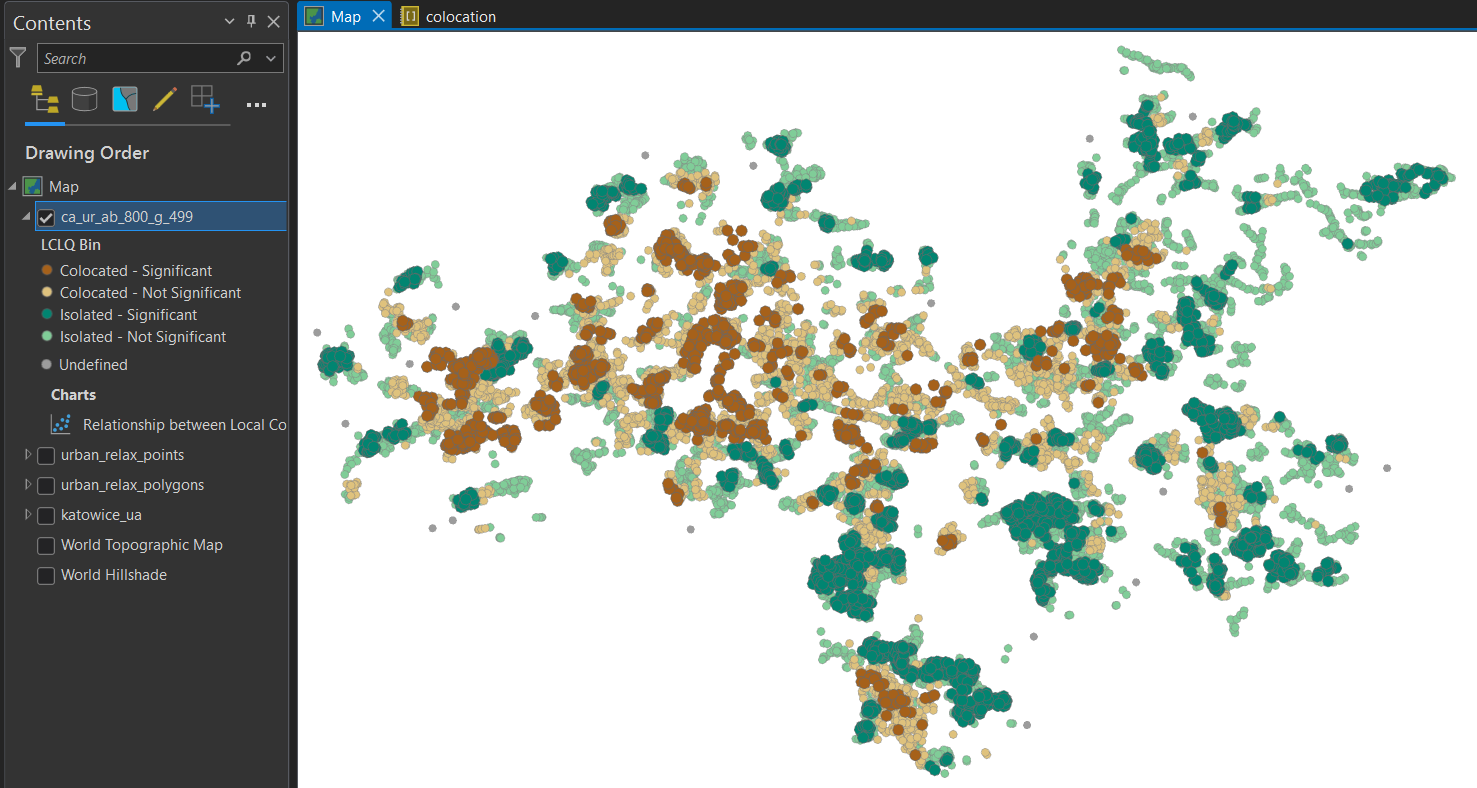

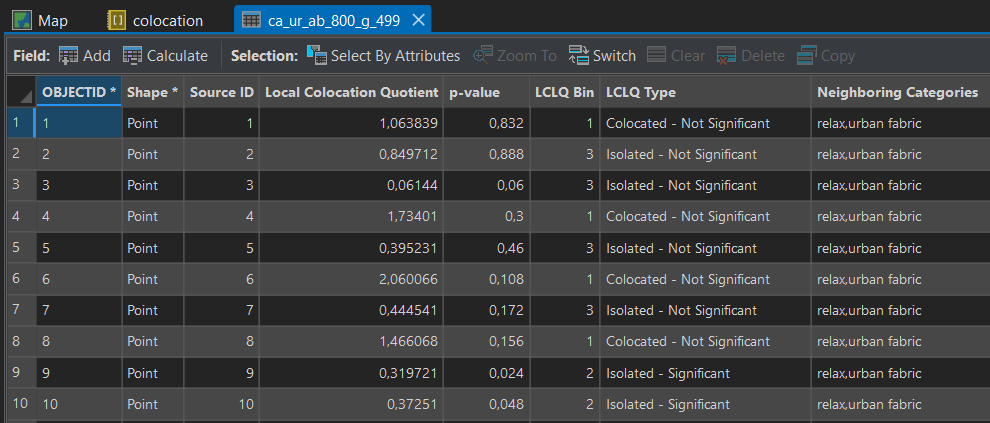

## Spatial interpretation of the results <a class= "anchor" id="interpretation"></a>

Let's take a better look at the ```"ca_ur_ab_800_g_499"``` output layer in the spatial context. For this part you'll need to follow both the notebook and the map. It's up to you how you're going to do it, you can switch between them or split the screen in half or if you have two monitors place the notebook on one and map on the other.

In order to get the better view at the results and the source data, select ```"urban fabric"``` and ```"relax"``` polygons from the polygon source layer and export them into a new layer named ```"urban_relax_polygons"```.

In [ ]:
ab_polygons = "urban_relax_polygons"

if arcpy.Exists(ab_polygons):
    print("A polygon layer containing only A and B categories already exists in your geodatabase.")
else:
    ab_only = arcpy.management.SelectLayerByAttribute(source_clipped, "NEW_SELECTION",
                                "ctgr_group = 'urban fabric' OR ctgr_group = 'relax'")
    arcpy.conversion.ExportFeatures(ab_only, ab_polygons)
    arcpy.management.SelectLayerByAttribute(source_clipped, "CLEAR_SELECTION")
    print("A polygon layer containing only A and B categories was successfully created.")

Now change the field of unique values symbology from ```"code_2018"``` to ```"ctgr_group"``` using map layer [symbology](https://pro.arcgis.com/en/pro-app/latest/arcpy/mapping/symbology-class.htm) property.

In [ ]:
l = my_map.listLayers(ab_polygons)[0]
lsym = l.symbology

lsym.updateRenderer('UniqueValueRenderer')
lsym.renderer.fields = ["ctgr_group"]

Set the ```"relax"``` polygons color to green and ```"urban fabric"``` polygons color to red. Set the outline color to grey and the transparency to 50% for both groups.

In [ ]:
for g in lsym.renderer.groups:
    for i in g.items:
        # https://pro.arcgis.com/en/pro-app/latest/arcpy/mapping/symbol-class.htm
        i.symbol.outlineColor = {'RGB' : [110, 110, 110, 50]}
        if i.label == "relax":
            i.symbol.color = {'RGB' : [140, 220, 0, 50]}
        else:
            i.symbol.color = {'RGB' : [255, 64, 64, 50]}
        
# save the updated colors to the layer's symbology property
l.symbology = lsym

Make sure that the ```"urban_relax_polygons"```, ```"ca_ur_ab_800_g_499"``` and the esri topographic basemap layers are visible in the map and turn off all other layers. You can do that using the [visible](https://pro.arcgis.com/en/pro-app/3.1/arcpy/mapping/layer-class.htm) property of map layer.

In [ ]:
for l in my_map.listLayers():
    if (l.name == 'urban_relax_polygons') or (l.name == 'ca_ur_ab_800_g_499') or (l.name == 'World Topographic Map'):
        if l.visible == False:
            l.visible = True
    else:
        if l.visible == True:
            l.visible = False

There are 7 bookmarks saved in the map. These bookmarks will guide you through the CA results in the Katowice conurbation. Let's check their names.

In [ ]:
my_bookmarks = my_map.listBookmarks()
for b in my_bookmarks:
    print(b.name)

Now zoom to a **cluster of isolated** points, which in this case means cluster of urban fabric points surrounded with very little or no relax points. Let's start in Myslowice.

In [ ]:
my_view = project.activeView
my_view.zoomToBookmark(my_bookmarks[2])

You can see that there are a lot of urban fabric points, possibly some residential buildings, there is a school, cemetary and car services visible from the basemap, but there is a lack of public green areas or sports facilities.

In [ ]:
my_view.zoomToBookmark(my_bookmarks[3])

This bookmark shows an **isolated cluster** in Jaworzno and it looks like that there should be more relax points in this area. At least from the basemap is seems like there are quite a lot of green spaces around. Check what are these areas according to Urban Atlas. 

In [ ]:
my_map.listLayers(source_clipped)[0].visible = True

These green spaces are forests which haven't been added to the relax group, but this view suggest that it could bring some interesting CA results if forests are a part of the relax group too. Feel free to try it.

In [ ]:
my_map.listLayers(source_clipped)[0].visible = False

Let's zoom to a **colocated cluster** now, for example in Sosnowiec.

In [ ]:
my_view.zoomToBookmark(my_bookmarks[4])

You can see a good mixture of urban fabric and relax areas in a typical urban area without nearby forests. Local people can go to parks and school students can use their sports areals and facilities. 

In [ ]:
my_view.zoomToBookmark(my_bookmarks[5])

This **cluster of colocated** points is in the centre of Ruda Slaska. If you pan the map just a bit to the north, you'll find another colocated cluster.

In [ ]:
my_view.zoomToBookmark(my_bookmarks[0])

Now you see the whole Katowice conurbation and you can say that **colocated** points prevail in the **centre** and in the **north-west** part, whereas the **isolated** points dominate mostly on the **outskirts** and in the **south-east** part of the conurbation. The city of **Tychy** in the south is somewhat independent in this respect, it has both colocated and isolated clusters.

Feel free to go through all the bookmarks, change basemaps, explore the spatial patterns.

## Running multiple analyses <a class="anchor" id="multiple"></a>

The next cells set up parameters for multiple colocation analyses which will be run in a loop. Feel free to change the parameter's values and experiment with settings.

Input type and input feature class stay the same. An empty list for the output layer names is created and named ```outfc_list```.

In [ ]:
input_type = "SINGLE_DATASET"
infoi = ab_points  #"urban_relax_points"
outfc_list = []

Category of interest and neighbouring category remain the same as well as the field where the information about point's category is stored.

In [ ]:
field = new_field  #ctgr_group
cat_interest = "urban fabric"
neigh_cat = "relax"

Let's experiment with the neighbourhood size and run the CA with *```400```*, *```800```* and *```1600```* m distance band.

In [ ]:
neighbourhood = "DISTANCE_BAND"
distance = ["400 Meters", "800 Meters", "1600 Meters"]

You'll compare how *```499```* vs. *```9999```* permutations and ```"GAUSSIAN"``` vs. ```"BISQUARE"``` local weighting scheme affect the result.

In [ ]:
permutations = [499, 9999]
weighting = ["GAUSSIAN", "BISQUARE"]

The CA will be run 12 times because there are 3 distances, 2 permutations counts and 2 local weighting schemes which needs to be combined. Quick math gives you 3 x 2 x 2 = 12 combinations. The output layer name will be printed after each iteration. This next cell can keep the kernel busy for around 5 minutes.

In [ ]:
for d in distance:
    # d_name is a list containing 2 elements: number and unit
    # for example if d is '800 Meters', d_name is ['800', 'Meters']
    d_name = d.split()
    for w in weighting:
        for p in permutations:
            # the name of the output layer contains the distance band, number of permutations 
            # and the first letter of local weighting scheme, either 'g' or 'b'
            outfc_list.append("ca_ur_ab_" + d_name[0] + "_" + w[0].lower() + "_" + str(p))
            arcpy.stats.ColocationAnalysis(input_type, infoi, outfc_list[len(outfc_list)-1], 
                                           field, None, cat_interest, None, None, None, 
                                           neigh_cat, neighbourhood, None, d, 
                                           None, None, None, p, w, None)
            print(f"output layer named {outfc_list[len(outfc_list)-1]} was created")

Create a group in the map contents pane named ```"CA outputs"```.

In [ ]:
if len(my_map.listLayers("CA outputs")) == 0:
    my_map.createGroupLayer("CA outputs")
else:
    print('Group with a name "CA outputs" already exists in the map contents pane.')

Add the CA output layers into the group and remove them from the map contents pane. When grouping layers via **ArcPy**, they are not moved but copied to a group and then they are duplicated. That's why you need to remove them after adding them to the group.

In [ ]:
my_group = my_map.listLayers("CA outputs")[0]

for i in outfc_list:
    l =  my_map.listLayers(i)[0]
    my_map.addLayerToGroup(my_group, l)
    my_map.removeLayer(l)

Now you've got all output layers in one group and it's recommended to collapse them and turn them off. It'll help to keep the map and contents pane clear.

## Visualization of results by chart <a class="anchor" id="charts"></a>

Now you are going to create a chart using [**matplotlib**](https://matplotlib.org/). This chart will visualize the outputs of the 12 CA run in the previous part.

As the first step you'll create a [dictionary](https://www.w3schools.com/python/python_dictionaries.asp) named ```cadict``` where you'll store necessary information about the CA results.

Full names of the output layers will be values to the key ```"ca_type"```.

Shortened names containing information about the CA settings will be values to the key ```"dist_weight_permut"```.

Numbers of colocated and isolated points will be values to the keys ```"colocated_points"``` and ```"isolated_points"```.

In [ ]:
cadict = {"ca_type": outfc_list, 
          "dist_weight_permut": [], 
          "colocated_points": [], 
          "isolated_points": []}

for i in outfc_list:
    cadict["dist_weight_permut"].append(i[9:])

Now get the number of significantly colocated and isolated points for each output layer.

In [ ]:
lclq_type = ["Colocated - Significant", "Isolated - Significant"]

for i in lclq_type:
    for j in outfc_list:
        selection = arcpy.management.SelectLayerByAttribute(j, "NEW_SELECTION", "LCLQTYPE = '"+ i +"'")
        if i == "Colocated - Significant":
            cadict["colocated_points"].append(int(selection[1]))
        else:
            cadict["isolated_points"].append(int(selection[1]))
        my_map.removeLayer(my_map.listLayers("*_Layer*")[0])

print("Counting successful.")

It is very convenient to create charts in **matplotlib** from the [**pandas**](https://pandas.pydata.org/) [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) structure. Therefore create a dataframe named ```df``` from the dictionary ```cadict```. 

Dataframes also provide a friendly tabular interface, so you can take a look at the data you just gathered.

In [65]:
import pandas as pd

df = pd.DataFrame(cadict)
df

,ca_type,dist_weight_permut,colocated_points,isolated_points
0,ca_ur_ab_400_g_499,400_g_499,456,378
1,ca_ur_ab_400_g_9999,400_g_9999,464,386
2,ca_ur_ab_400_b_499,400_b_499,609,382
3,ca_ur_ab_400_b_9999,400_b_9999,624,390
4,ca_ur_ab_800_g_499,800_g_499,1039,2434
5,ca_ur_ab_800_g_9999,800_g_9999,1068,2501
6,ca_ur_ab_800_b_499,800_b_499,1453,2649
7,ca_ur_ab_800_b_9999,800_b_9999,1468,2695
8,ca_ur_ab_1600_g_499,1600_g_499,1975,3577
9,ca_ur_ab_1600_g_9999,1600_g_9999,1998,3616


The next step is to import [**matplotlib.pyplot**](https://matplotlib.org/stable/tutorials/pyplot.html) and ensure that **matplotlib** charts will be included and saved in this notebook as the outputs of the code cells. You can achieve this by using the ```%matplotlib inline``` command. Otherwise the charts will be returned in a new *figure* window and will not be a part of the notebook.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

This next code cell is a bit larger because it includes all the settings for the chart. It will display the dataframe as a stacked bar chart. Feel free to change the settings, you can help yourself with this [stacked bar chart tutorial](https://python-charts.com/part-whole/stacked-bar-chart-matplotlib/) or [**matplotlib** documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bar.html).

[55]:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
[55]:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


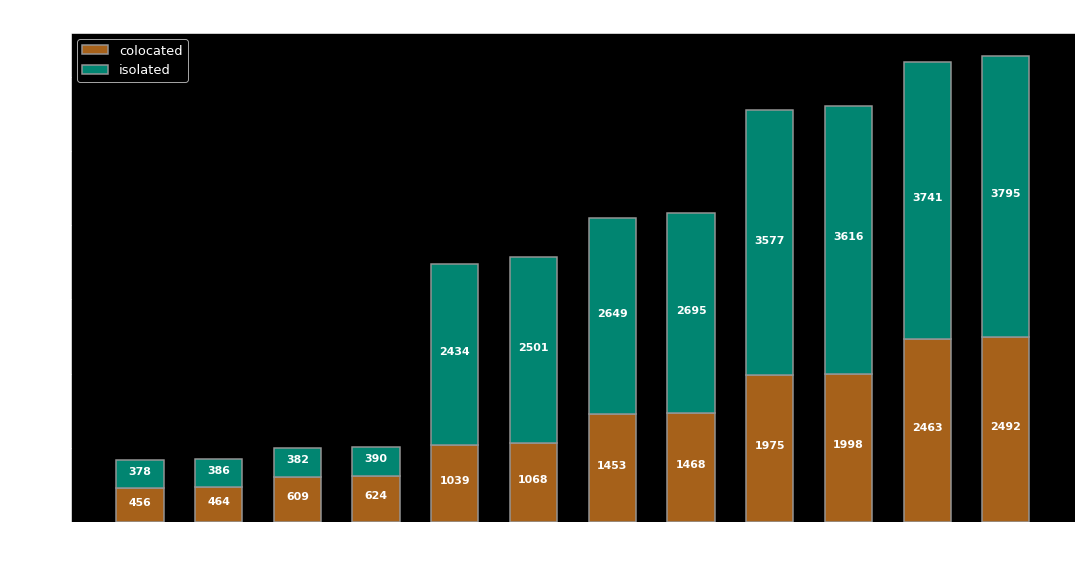

In [55]:
# chart width and height
plt.rcParams['figure.figsize'] = [18, 9]
fig, ax = plt.subplots()

# colocated points bar on the bottom
ax.bar(df['dist_weight_permut'], df['colocated_points'], 
       color = "#A6611A", edgecolor = "#969696", linewidth = 1.5,
       width = 0.6, label = 'colocated')

# isolated points bar on the top
ax.bar(df['dist_weight_permut'], df['isolated_points'], bottom = df['colocated_points'], 
       color = "#018571", edgecolor = "#969696", linewidth = 1.5,
       width = 0.6, label = 'isolated')

# labels inside the bars showing the number of colocated and isolated points
for bar in ax.patches:
  ax.text(bar.get_x() + bar.get_width() / 2,
          bar.get_height() / 2 + bar.get_y(),
          round(bar.get_height()), ha = 'center',
          color = 'w', weight = 'bold', size = 11)

# chart title, axes labels and legend
ax.set_title(label = "Number of significantly colocated and isolated points", fontsize = 18, pad = 12.0)
ax.set_xlabel('CA type (distance_weighting_permutations)', fontsize = 14, labelpad = 14.0)
ax.set_ylabel('number of points', fontsize = 14, labelpad = 14.0)
ax.legend(loc = 'upper left', fontsize = 13)

# chart axes tick labels
ax.set_xticklabels(df['dist_weight_permut'], fontsize = 11.3)
ax.set_yticklabels([0, 1000, 2000, 3000, 4000, 5000, 6000], fontsize = 11.3)

# chart "print" command
plt.show()

There are 3 "jumps" in the number of points visible from the chart. 

1. The biggest one is related to the size change of the **distance band**. The greater the distance, the greater the number of significantly collocated and isolated points (NSCIP). An interesting fact connected to the distance band is that with *```400```* m distance band the **N colocated points > N isolated points**, whereas with *```800```* and *```1600```* m distance band it's the other way round.


2. The second "jump" is related to the type of **local weighting scheme**. When the ```"Bisquare"``` weighting was applied the NSCIP was greater than when the ```"Gaussian"``` weighting was used. This is caused by the nature of these weighting schemes: ```"Gaussian"``` has a steeper decline in the weight assigned to neighbouring points than ```"Bisquare"``` (check the [picture](#weighting) in the *"Colocation analysis settings"* part), that decreases the number of important neighbouring points and that decreases the significance of the LCLQ.


3. The last and smallest "jump" is related to the number of **permutations**. The **CA tool** documentation says that "with *```499```* and *```9999```* permutations, the smallest possible pseudo p-value is 0.004 and 0.0002, respectively, and all other pseudo p-values will be even multiples of this value." Using more permutations leads to more detailed, precise p-value and that causes a slight increase in the NSCIP.

## Calculation of colocation quotient  <a class="anchor" id="math"></a>

In this part you will calculate the LCLQ by yourself. For better understanding you will work with no local weighting scheme, therefore run the **CA tool** again with ```"NONE"``` assigned to the parameter ```weighting```.

In [ ]:
outfc = "ca_ur_ab_800_none_499"
distance = "800 Meters"
permutations = 499
weighting = "NONE"

In [ ]:
arcpy.stats.ColocationAnalysis(input_type, infoi, outfc, 
                               field, None, cat_interest, None, None, None, 
                               neigh_cat, neighbourhood, None, distance, 
                               None, None, None, permutations, weighting, None)

The following cells will gather necessary numbers for the LCLQ calculation.

Get the number of all points in the input layer and save it in the variable ```N``` using the [**Get Count**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/get-count.htm) tool.

In [58]:
N = int(arcpy.management.GetCount(ab_points)[0])
N

14174

Get the number of all B points (```"relax"``` points) in the input layer and save it in the variable ```Nb```.

In [59]:
Nb = int(arcpy.management.SelectLayerByAttribute(ab_points, "NEW_SELECTION", "ctgr_group = 'relax'")[1])
arcpy.management.SelectLayerByAttribute(ab_points, "CLEAR_SELECTION")
Nb

2429

Choose a point from the output layer and save its LCLQ in the variable ```my_lclq```. Select it then and export into a new layer named ```"Ai_point"```.

In [ ]:
my_lclq = 2.857915829979583
aipoint = arcpy.management.SelectLayerByAttribute(outfc, "NEW_SELECTION", f"LCLQ = {str(my_lclq)}")
arcpy.conversion.ExportFeatures(aipoint, "Ai_point")

if len(my_map.listLayers("*_Layer*")) > 0:
    my_map.removeLayer(my_map.listLayers("*_Layer*")[0])
arcpy.management.SelectLayerByAttribute(outfc, "CLEAR_SELECTION")

Select neighbouring points (points from the input layer in the 800 m distance band) of your chosen point and export them into a new layer named ```"neigh_points"```.

In [ ]:
neigh_points = arcpy.management.SelectLayerByLocation(infoi, "INTERSECT", "Ai_point", 
                                                      distance, "NEW_SELECTION", "NOT_INVERT")
arcpy.conversion.ExportFeatures(neigh_points, "neigh_points")
arcpy.management.SelectLayerByAttribute(infoi, "CLEAR_SELECTION")

Get the number of the neighbouring points. You can use the **Get Count** tool or the variable ```neigh_points``` from the previous cell. The selection output is stored there and the 3rd index is the count of selected records. 

In [62]:
neigh_points = int(neigh_points[2])
neigh_points

50

Get the number of the neighbouring B points.

In [63]:
neigh_b_points = int(arcpy.management.SelectLayerByAttribute("neigh_points", "NEW_SELECTION", 
                                                             "ctgr_group = 'relax'")[1])
arcpy.management.SelectLayerByAttribute("neigh_points", "CLEAR_SELECTION")
neigh_b_points

24

Now you've got all of the necessary data to calculate the LCLQ. Here's the formula from the esri documentation [How Colocation Analysis works](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/learnmorecolocationanalysis.htm):

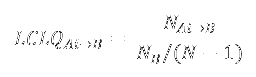

*Nai->b* is the ratio of B points in the neighbourhood of chosen A point. Variable ```neigh_points``` stores the number of neighbouring points, but it includes the chosen A point as well. Therefore there is *```neigh_points-1```* in the code.
Compare your calculation with the LCLQ produced by the **CA tool**.

In [64]:
calc_lclq = (neigh_b_points/(neigh_points-1))/(Nb/(N-1))
print(f"      Manually calculated LCLQ: {calc_lclq}")
print(f"LCLQ calculated by the CA tool: {my_lclq}")

      Manually calculated LCLQ: 2.857915829979583
LCLQ calculated by the CA tool: 2.857915829979583


If the ratio of B points in the neighbourhood (neighbouring points) is greater than the ratio of B points in the whole area (all points in the layer), then LCLQ is greater than 1 and you can say that the A point is colocated.  
If the ratio of B points in the neighbourhood is smaller than the ratio of B points in the whole area, then LCLQ is smaller than 1 and the A point is isolated.